# Import Libraries

In [1]:
import numpy as np
import pandas as pd 
import keras
from keras.layers import Input, Dense, Reshape, Flatten, Dropout,Concatenate
from keras.backend import random_normal,ones_like,zeros_like,mean
from keras.backend import get_session
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import concatenate
from keras.initializers import TruncatedNormal
from keras.callbacks import LearningRateScheduler, EarlyStopping, History
from PIL import Image
import warnings
import os
import time
from glob import glob
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np, pandas as pd, os
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt, zipfile 
from PIL import Image 
from glob import glob

Using TensorFlow backend.


In [2]:
print(os.listdir("../input/"))

['all-dogs', 'annotation']


# Load Images

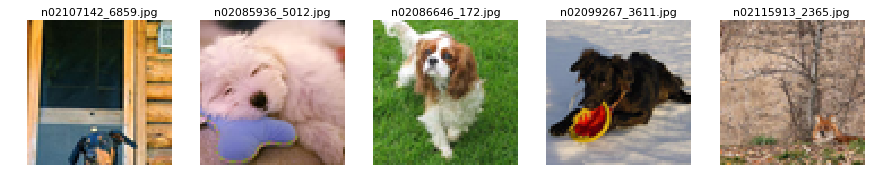

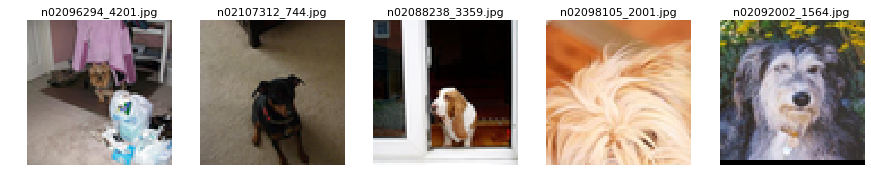

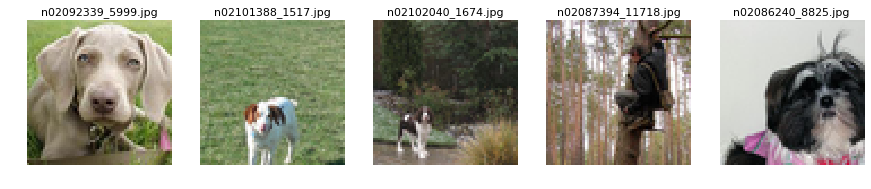

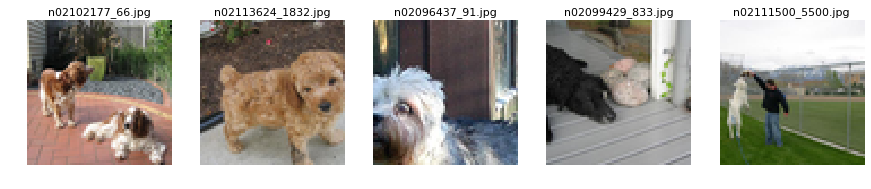

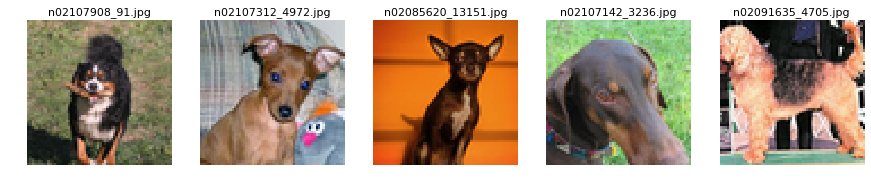

In [3]:
ComputeLB = False
DogsOnly = False

import numpy as np, pandas as pd, os
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt, zipfile 
from PIL import Image 

ROOT = '../input/gan/'
if not ComputeLB: ROOT = '../input/'
IMAGES = os.listdir(ROOT + 'all-dogs/all-dogs/')
breeds = os.listdir(ROOT + 'annot/annot/') 

idxIn = 0; namesIn = []
imagesIn = np.zeros((25000,64,64,3))
 
if DogsOnly:
    for breed in breeds:
        for dog in os.listdir(ROOT+'annot/annot/'+breed):
            try: img = Image.open(ROOT+'all-dogs/all-dogs/'+dog+'.jpg') 
            except: continue           
            tree = ET.parse(ROOT+'annot/annot/'+breed+'/'+dog)
            root = tree.getroot()
            objects = root.findall('object')
            for o in objects:
                bndbox = o.find('bndbox') 
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                w = np.min((xmax - xmin, ymax - ymin))
                img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
                img2 = img2.resize((64,64), Image.ANTIALIAS)
                imagesIn[idxIn,:,:,:] = np.asarray(img2) 
                namesIn.append(breed)
                idxIn += 1
    idx = np.arange(idxIn)
    np.random.shuffle(idx)
    imagesIn = imagesIn[idx,:,:,:]
    namesIn = np.array(namesIn)[idx]
     
else:
    IMAGES = np.sort(IMAGES)
    np.random.seed(810)
    x = np.random.choice(np.arange(20579),10000)
    np.random.seed(None)
    for k in range(len(x)):
        img = Image.open(ROOT + 'all-dogs/all-dogs/' + IMAGES[x[k]])
        w = img.size[0]; h = img.size[1];
        if (k%2==0)|(k%3==0):
            w2 = 100; h2 = int(h/(w/100))
            a = 18; b = 0          
        else:
            a=0; b=0
            if w<h:
                w2 = 64; h2 = int((64/w)*h)
                b = (h2-64)//2
            else:
                h2 = 64; w2 = int((64/h)*w)
                a = (w2-64)//2
        img = img.resize((w2,h2), Image.ANTIALIAS)
        img = img.crop((0+a, 0+b, 64+a, 64+b))    
        imagesIn[idxIn,:,:,:] = np.asarray(img)
        namesIn.append(IMAGES[x[k]]) 
        idxIn += 1
     
x = np.random.randint(0,idxIn,25)
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray( imagesIn[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')
        if not DogsOnly: plt.title(namesIn[x[k*5+j]],fontsize=11)
        else: plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show()

# Variables used

In [4]:
IMG_SIZE = Input((12288,))
IMG_SIZE_2 = Input((10000,))
NOISE_SIZE = 10000
BATCH_SIZE = 128

# Build Generator

In [7]:
def GeneratorFunction(noise_shape=(NOISE_SIZE,)):
    input_layer = Input(noise_shape)
    generated = Dense(12288, activation='linear')(input_layer)
        
# COMPILE
    model = Model(inputs=input_layer,outputs = [generated,Reshape((10000,))(input_layer)])
    model.summary()
  
    return model

In [8]:
print("Generator")
model_generator = GeneratorFunction(noise_shape=(NOISE_SIZE,))

Generator
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 10000)        0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 12288)        122892288   input_3[0][0]                    
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 10000)        0           input_3[0][0]                    
Total params: 122,892,288
Trainable params: 122,892,288
Non-trainable params: 0
__________________________________________________________________________________________________


# Train the Discriminator

In [9]:
# TRAINING DATA
train_y = (imagesIn[:10000,:,:,:]/255.).reshape((-1,12288))
train_X = np.zeros((10000,10000))
for i in range(10000): train_X[i,i] = 1
zeros = np.zeros((10000,12288))

# ---------------------
#  Train Discriminator
# ---------------------

lr = 0.5
for k in range(5):
    LR_Scheduler = LearningRateScheduler(lambda x: lr)
    h = model_discriminator.fit([zeros,train_X], train_y, epochs = 100,batch_size = BATCH_SIZE, callbacks=[LR_Scheduler], verbose=0)
    print('Epoch',(k+1)*10,'/50 - loss =',h.history['loss'][-1] )
    if h.history['loss'][-1]<0.533: lr = 0.1

Epoch 10 /50 - loss = 0.5324619684696198
Epoch 20 /50 - loss = 0.5324463943481446
Epoch 30 /50 - loss = 0.5324408501625061
Epoch 40 /50 - loss = 0.5324368857383728
Epoch 50 /50 - loss = 0.5324339078426361


In [10]:
del train_X, train_y, imagesIn

# Build the GAN

In [12]:
# BUILD GENERATIVE ADVERSARIAL NETWORK
model_discriminator.trainable = False #discriminator is not trainable for GANs
z = Input(shape=(NOISE_SIZE,))
img = model_generator(z)
real = model_discriminator(img)

# COMPILE GAN
gan = Model(z, real)
gan.get_layer('model_1').get_layer('layer_1').set_weights([np.array([[[[-1 ]]],[[[255.]]]])])
gan.compile(optimizer=Adam(5), loss='mean_squared_error')

# DISPLAY ARCHITECTURE
print("Model created based on Discriminator and Generator")
gan.summary()

Model created based on Discriminator and Generator
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 10000)        0                                            
__________________________________________________________________________________________________
model_2 (Model)                 [(None, 12288), (Non 122892288   input_4[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 12288)        122892290   model_2[1][0]                    
                                                                 model_2[1][1]                    
Total params: 245,784,578
Trainable params: 122,892,288
Non-trainable params: 122,892,290
___________________________________________________________________

# Train the GAN

In [13]:
train = np.zeros((10000,10000))
for i in range(10000): train[i,i] = 1
zeros = np.zeros((10000,12288))

Steps_per_epoch = 50

print("Training begins... Total steps per epoch: {}".format(Steps_per_epoch ))


Training begins... Total steps per epoch: 50


# Submit to Kaggle

In [15]:
class DogGenerator:
    index = 0   
    def getDog(self,seed):
        xx = np.zeros((10000))
        xx[self.index] = 0.999
        xx[np.random.randint(10000)] = 0.001
        img = model_generator.predict(xx.reshape((-1,10000)))[0].reshape((64,64,3))
        self.index = (self.index+1)%10000
        return Image.fromarray( img.astype('uint8') ) 